In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm

from lgde import BaseExpansion, Thresholding, LGDE, evaluate_prediction

In [2]:
plt.rcParams.update({'font.size': 20})

# Application to conspiracy-related content on 4chan

## 1) Data input and pre-processing

In [3]:
# load train data
corpus_train = pd.read_csv("data/4chan_train.csv", delimiter=",", encoding="utf-8")
X_train = corpus_train["text"]
y_train = np.asarray(corpus_train["v1"])

# load test data
corpus_test = pd.read_csv("data/4chan_test.csv", delimiter=";", encoding="utf-8")
corpus_test["V1_majority"] = corpus_test["V1_majority"].apply(lambda x : 1 if x=="Yes" else 0)
X_test = corpus_test["text"]
y_test = corpus_test["V1_majority"]

In [4]:
# load seed keywords
df_keywords = pd.read_csv("data/4chan_seed.csv", encoding="utf-8")
seed_dictionary = list(df_keywords["keyword_ger"].dropna())
# combine phrases by underscores
seed_dictionary_underscored = [kw.replace(" ","_") for kw in seed_dictionary]
print('Number of keywords in seed dictionary:', len(seed_dictionary_underscored))
print('First 5 keywords in seed dictionary:', seed_dictionary_underscored[:5])

Number of keywords in seed dictionary: 215
First 5 keywords in seed dictionary: ['14_words', '14_worte', '14words', 'abolition_of_the_german_people', 'abolition_of_the_occident']


In [5]:
# load vocabulary
df_vocabulary = pd.read_pickle("data/4chan_embeddings_100d.pkl")
df_vocabulary.reset_index(inplace=True,drop=True)
print('Size of vocabulary:', len(df_vocabulary))

# combine phrases with underscore
word_string_original = df_vocabulary["word_string"]
word_string_underscored = [df_vocabulary.word_string[i].replace(" ","_") for i in range(len(df_vocabulary))]
df_vocabulary["word_string"] = word_string_underscored
df_vocabulary.head()

Size of vocabulary: 5000


,word_string,word_vector,sentence_frequency,doc_frequency
0,like,"[0.31141145176294316, 1.8499041093908692, 0.92...",22951,18534
1,people,"[-0.004248023128069267, 1.6205275020827639, -0...",25382,18817
2,want,"[0.39601273048344754, 0.8807747644923307, 0.51...",14358,11922
3,think,"[0.09862071784419435, 1.2564331005861358, 0.86...",13533,11292
4,know,"[-0.14643477004382777, 0.9906227050244074, 0.9...",13958,11590


In [6]:
# store word vectors in matrix
W = np.zeros((df_vocabulary["word_vector"].shape[0], df_vocabulary["word_vector"][0].shape[0]))
for i in range(W.shape[0]):
    W[i, :] = df_vocabulary["word_vector"][i]

In [7]:
# create dictionary for phrases
word_string_underscored_dict = {}
for i in range(len(df_vocabulary)):
    word = word_string_original[i]
    if " " in word:
        word_string_underscored_dict[word] = word.replace(" ","_")

# make train and test data lower case
X_train_underscored = X_train.str.lower()
X_test_underscored = X_test.str.lower()

# combine phrases in train and test data with underscore
for old, new in word_string_underscored_dict.items():

    X_train_underscored = X_train_underscored.str.replace(old, new, regex=False)
    X_test_underscored = X_test_underscored.str.replace(old, new, regex=False)

In [8]:
# compute document-term matrix for train data
vectorizer = CountVectorizer(vocabulary=df_vocabulary["word_string"])
word_counts_train = vectorizer.fit_transform(np.asarray(X_train_underscored)).toarray()
dt_train = pd.DataFrame(word_counts_train, columns=df_vocabulary["word_string"])

# and for test data
word_counts_test = vectorizer.fit_transform(np.asarray(X_test_underscored)).toarray()
dt_test = pd.DataFrame(word_counts_test, columns=df_vocabulary["word_string"])

We summarise the ingredients we need for dictionary expansion:

In [9]:
seed_dict = seed_dictionary_underscored
word_list = word_string_underscored
word_vecs = W
doc_freq = df_vocabulary["doc_frequency"]

## 2) Properties of seed dictionary

In [10]:
baseline = BaseExpansion(seed_dict,word_list,word_vecs)
print("Size of effective seed dictionary:", baseline.n_seed)

Size of effective seed dictionary: 109


In [11]:
# evaluate effective seed dictionary on train
print("Train scores for seed dictionary:\n")
_,_,_ = evaluate_prediction(baseline.seed_dict, y_train, dt_train)

# evaluate effective seed dictionary on test
print("\nTest scores for seed dictionary:\n")
_,_,_ = evaluate_prediction(baseline.seed_dict, y_test, dt_test)

Train scores for seed dictionary:

              precision    recall  f1-score   support

       False      0.071     0.015     0.025        65
        True      0.868     0.970     0.916       435

    accuracy                          0.846       500
   macro avg      0.470     0.493     0.471       500
weighted avg      0.765     0.846     0.801       500


Test scores for seed dictionary:

              precision    recall  f1-score   support

       False      0.720     0.987     0.832       156
        True      0.818     0.130     0.225        69

    accuracy                          0.724       225
   macro avg      0.769     0.559     0.529       225
weighted avg      0.750     0.724     0.646       225



## 3) Thresholding approach to dictionary expansion

### 3.1) Hyperparameter tuning for thresholding approach

In [12]:
epsilons = np.arange(0.5,0.85,0.001)
size_threshold_expansion = np.zeros_like(epsilons)
precision_eps = np.zeros_like(epsilons)
recall_eps = np.zeros_like(epsilons)
fscore_eps = np.zeros_like(epsilons)
fscore_test_eps = np.zeros_like(epsilons)

# create copy
thres_temp = Thresholding(seed_dict,word_list,word_vecs)

for i, epsilon in tqdm(enumerate(epsilons), total=len(epsilons)):
    # compute epsilon balls around keywords
    thres_temp.expand(epsilon=epsilon)
    size_threshold_expansion[i] = len(thres_temp.discovered_dict_)
    p, r, f = evaluate_prediction(thres_temp.discovered_dict_, y_train, dt_train, with_report=False)
    precision_eps[i] = p
    recall_eps[i] = r
    fscore_eps[i] = f
    _, _, f_test = evaluate_prediction(thres_temp.discovered_dict_, y_test, dt_test, with_report=False)
    fscore_test_eps[i] = f_test

100%|██████████| 350/350 [00:03<00:00, 106.97it/s]


In [13]:
# apply size constraint
max_size = 150
fscore_eps_max = fscore_eps.copy()
fscore_eps_max[size_threshold_expansion>max_size] = np.NaN

# determine best epsilon and report scores
ind = np.nanargmax(fscore_eps_max)
best_epsilon = epsilons[ind]
print("Best epsilon:",best_epsilon)
print("Size:",size_threshold_expansion[ind])
print("Precision:",precision_eps[ind])
print("Recall:",recall_eps[ind])
print("F1score:",fscore_eps[ind])

Best epsilon: 0.7300000000000002
Size: 148.0
Precision: 0.5861902834788306
Recall: 0.6581786030061891
F1score: 0.5869648501101427


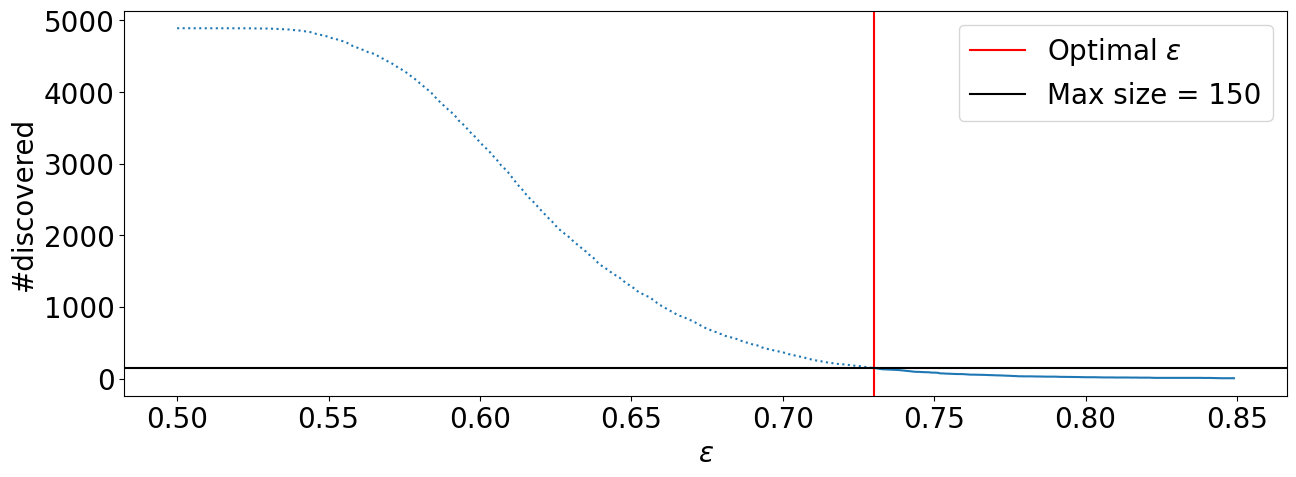

In [14]:
# plot sizes
fig, ax = plt.subplots(1, figsize=(15, 5))
ax.plot(epsilons[size_threshold_expansion>max_size],size_threshold_expansion[size_threshold_expansion>max_size],ls=":")
ax.plot(epsilons[size_threshold_expansion<=max_size],size_threshold_expansion[size_threshold_expansion<=max_size],color="C0")
ax.axvline(x=best_epsilon, c = 'r', label="Optimal $\epsilon$")
ax.set(xlabel="$\epsilon$", ylabel="#discovered")
ax.axhline(y=max_size,c="black", label="Max size = 150")
ax.legend()
plt.show()

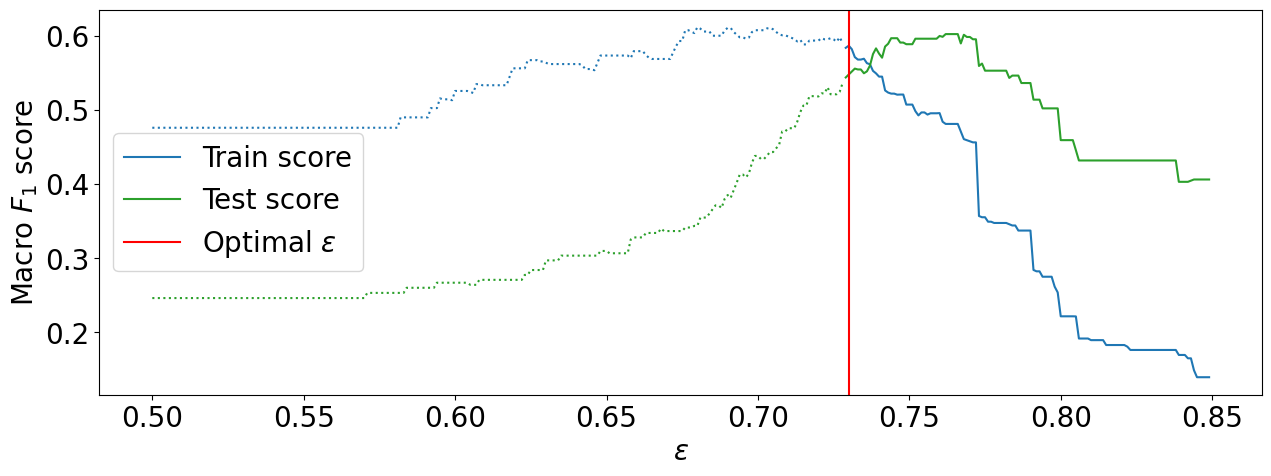

In [15]:
# plot scores
fig, ax = plt.subplots(1, figsize=(15, 5))
ax.plot(epsilons[size_threshold_expansion>max_size],fscore_eps[size_threshold_expansion>max_size],ls=":")
ax.plot(epsilons[size_threshold_expansion<=max_size],fscore_eps[size_threshold_expansion<=max_size],color="C0", label="Train score")

ax.plot(epsilons[size_threshold_expansion>max_size],fscore_test_eps[size_threshold_expansion>max_size],ls=":",c="C2")
ax.plot(epsilons[size_threshold_expansion<=max_size],fscore_test_eps[size_threshold_expansion<=max_size],color="C2",label="Test score")

ax.axvline(x=best_epsilon, c = 'red', label="Optimal $\epsilon$")
ax.set(xlabel="$\epsilon$",ylabel="Macro $F_1$ score")
ax.legend()
plt.show()

### 3.2) Optimal threshoding results

In [16]:
# expand with the optimal epsilon
thres = Thresholding(seed_dict,word_list,word_vecs)
thres.expand(best_epsilon)

print("Number of discovered keywords:", thres.n_discovered,"\n")

print("Epsilon balls:\n")
for keyword in thres.seed_dict[:15]:
    print(keyword,"-->",thres.epsilon_balls_[keyword])

print("\nDiscovered words:", sorted(thres.discovered_dict_))

Number of discovered keywords: 148 

Epsilon balls:

14_words --> ['14_words']
14words --> ['islamisierung', '14words']
ausrotten --> ['ausrotten']
ausrottung --> ['ausrottung']
bilderberg --> ['bilderberg']
bilderberg- --> ['bilderberg-']
bilderberg-club --> ['bilderberg-club']
bilderberg-conference --> ['bilderberg-conference']
bilderberg-conferences --> ['bilderberg-conferences']
bilderberger --> ['bilderberger']
bilderberger-conference --> ['bilderberger-conference']
bilderbergers --> ['bilderbergers']
bilderberg-group --> ['bilderberg-group']
bill_gates --> ['bill_gates', 'soros', 'george_soros']
birth-jihad --> ['birth-jihad']

Discovered words: ['2.', '3.', '9/11', 'act', 'admit', 'annihilate', 'annihilation', 'armenian', 'assassinate', 'assassination', 'assimilation', 'atrocity', 'attack', 'attempt', 'auschwitz', 'banish', 'bank', 'banker', 'basically', 'beaner', 'biden', 'billionaire', 'capitalism', 'capitalist', 'cia', 'colonize', 'commie', 'commit', 'communism', 'communist',

In [17]:
print("Train scores for thresholding discovered dictionary:\n")
_,_,_ = evaluate_prediction(thres.discovered_dict_, y_train, dt_train)

print("\nTest scores for thresholding expanded dictionary:\n")
_,_,_ = evaluate_prediction(thres.expanded_dict_, y_test, dt_test)

Train scores for thresholding discovered dictionary:

              precision    recall  f1-score   support

       False      0.252     0.569     0.349        65
        True      0.921     0.747     0.825       435

    accuracy                          0.724       500
   macro avg      0.586     0.658     0.587       500
weighted avg      0.834     0.724     0.763       500


Test scores for thresholding expanded dictionary:

              precision    recall  f1-score   support

       False      0.802     0.494     0.611       156
        True      0.388     0.725     0.505        69

    accuracy                          0.564       225
   macro avg      0.595     0.609     0.558       225
weighted avg      0.675     0.564     0.579       225



## 4) LGDE

### 4.1) Load LGDE grid search results

In [18]:
# load grid search results and unpack
with open("data/4chan_lgde_gridsearch.pkl", "rb") as handle:
    results = pickle.load(handle)

times = results["times"]
ks = results["ks"]
commmunities = results["communities"]
fscore_lgde = results["fscore"]
precision_lgde = results["precision"]
recall_lgde = results["recall"]
size_lgde = results["size"]

In [19]:
# apply size constraint
fscore_max_lgde = fscore_lgde.copy()
size_max_lgde = size_lgde.copy()
for ind_pair in np.argwhere(size_lgde > 150):
    fscore_max_lgde[ind_pair[0],ind_pair[1]] = np.NaN
    size_max_lgde[ind_pair[0],ind_pair[1]] = np.NaN

# determine best k and t and report scores
ind = tuple(np.argwhere(fscore_max_lgde == np.nanmax(fscore_max_lgde))[0])
best_k_lgde = ks[ind[0]]
best_t_lgde = times[ind[1]]
print("Best k:",best_k_lgde)
print("Best t:",best_t_lgde)
print("Size:",size_lgde[ind])
print("Precision:",precision_lgde[ind])
print("Recall:",recall_lgde[ind])
print("F1score:",fscore_lgde[ind])

Best k: 7
Best t: 1
Size: 149.0
Precision: 0.5607511045655376
Recall: 0.593368700265252
F1score: 0.3320984216537324


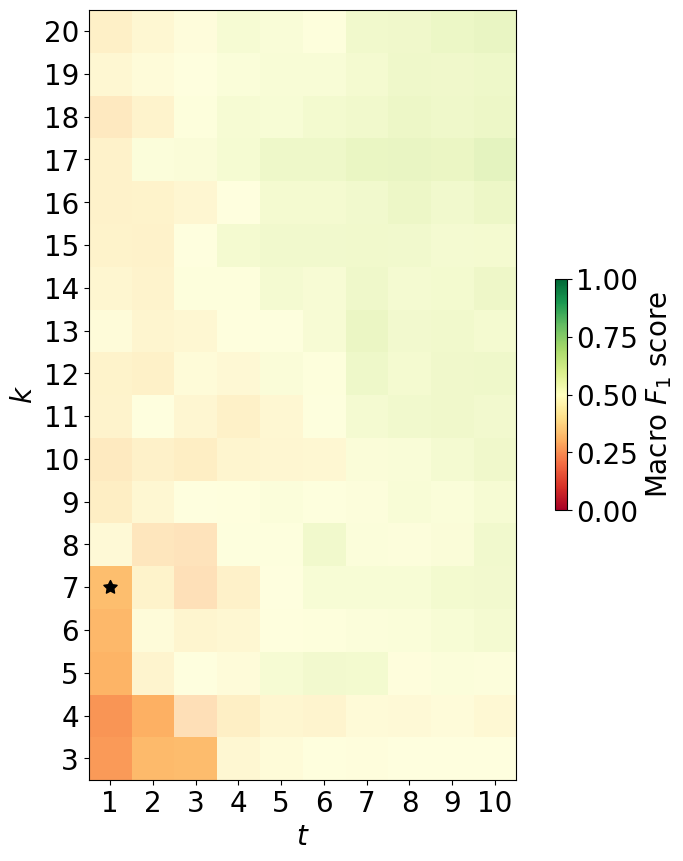

In [20]:
# plot F1 score
fig, ax = plt.subplots(1, figsize=(10, 10))
im = ax.imshow(fscore_lgde,cmap='RdYlGn',origin='lower',alpha=0.5,vmin=0,vmax=1)
im = ax.imshow(fscore_max_lgde,cmap='RdYlGn',origin='lower',vmin=0,vmax=1)
ax.set(xlabel="$t$", ylabel="$k$", xticks=np.arange(len(times)),yticks=np.arange(len(ks)), xticklabels=times, yticklabels=ks)
ax.scatter(ind[1],ind[0],color='black',marker=(5, 1),s=100)
plt.colorbar(im,shrink=0.3,label="Macro $F_1$ score")
plt.show()

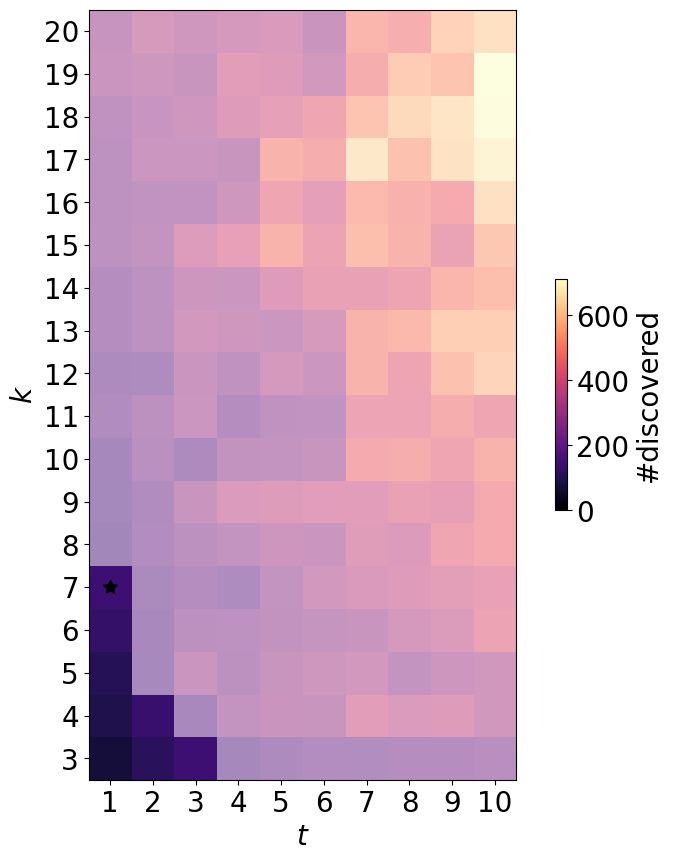

In [21]:
fig, ax = plt.subplots(1, figsize=(10, 10))
im = ax.imshow(size_lgde,cmap='magma',origin='lower',alpha=0.5,vmin=0,vmax=size_lgde.max())
im = ax.imshow(size_max_lgde,cmap='magma',origin='lower',vmin=0,vmax=size_lgde.max())
ax.set(xlabel="$t$", ylabel="$k$", xticks=np.arange(len(times)),yticks=np.arange(len(ks)), xticklabels=times, yticklabels=ks)
ax.scatter(ind[1],ind[0],color='black',marker=(5, 1),s=100)
plt.colorbar(im,shrink=0.3,label="#discovered")
plt.show()

## 4.2) Optimal LGDE results

In [22]:
# expand with optimal k and t
best_k_lgde = 7
best_t_lgde = 1
lgde = LGDE(seed_dict,word_list,word_vecs)
lgde.expand(best_k_lgde, best_t_lgde)

100%|██████████| 109/109 [01:15<00:00,  1.44it/s]


In [23]:
print("Number of discovered keywords:", lgde.n_discovered,"\n")
print("Semantic communities:\n")
for keyword in lgde.seed_dict[:10]:
    print(keyword,"-->",lgde.semantic_communities_[keyword])

print("\nDiscovered words:", sorted(lgde.discovered_dict_))

Number of discovered keywords: 149 

Semantic communities:

14_words --> ['14_words', 'end_game', 'mass_extinction']
14words --> ['14words', 'birth-jihad', 'islamisierung', 'judenrepublik', 'financial_lobby']
ausrotten --> ['ausrotten']
ausrottung --> ['ausrottung', 'elders_of_zion']
bilderberg --> ['bilderberg', 'nsg', 'imo', 'mental_illness', 'eas']
bilderberg- --> ['bilderberg-', 'bilderbergers']
bilderberg-club --> ['bilderberg-club', 'international_criminal_court', 'neue_weltordnung', 'general_public', 'afd', 'great_exchange']
bilderberg-conference --> ['bilderberg-conference']
bilderberg-conferences --> ['bilderberg-conferences', 'great_ally', 'video_game', 'good_job']
bilderberger --> ['bilderberger', 'jesus_christ', 'globalist_jews']

Discovered words: ['9/11', ':^', 'admit', 'adolf_hitler', 'afd', "ain't", 'alt_right', 'amalek', 'american_government', 'annihilation', 'architect', 'assimilation', 'atrocity', 'banker', 'bannon', 'beaner', 'billionaire', 'bioweapon', 'bogdanoffs'

In [24]:
print("Train scores for LGDE discovered dictionary:\n")
_,_,_ = evaluate_prediction(lgde.discovered_dict_, y_train, dt_train)

# evaluate effective seed dictionary on test
print("\nTest scores for LGDE expanded dictionary:\n")
_,_,_ = evaluate_prediction(lgde.expanded_dict_, y_test, dt_test)

Train scores for LGDE discovered dictionary:

              precision    recall  f1-score   support

       False      0.157     0.938     0.269        65
        True      0.964     0.248     0.395       435

    accuracy                          0.338       500
   macro avg      0.561     0.593     0.332       500
weighted avg      0.859     0.338     0.379       500


Test scores for LGDE expanded dictionary:

              precision    recall  f1-score   support

       False      0.754     0.923     0.830       156
        True      0.647     0.319     0.427        69

    accuracy                          0.738       225
   macro avg      0.700     0.621     0.629       225
weighted avg      0.721     0.738     0.706       225



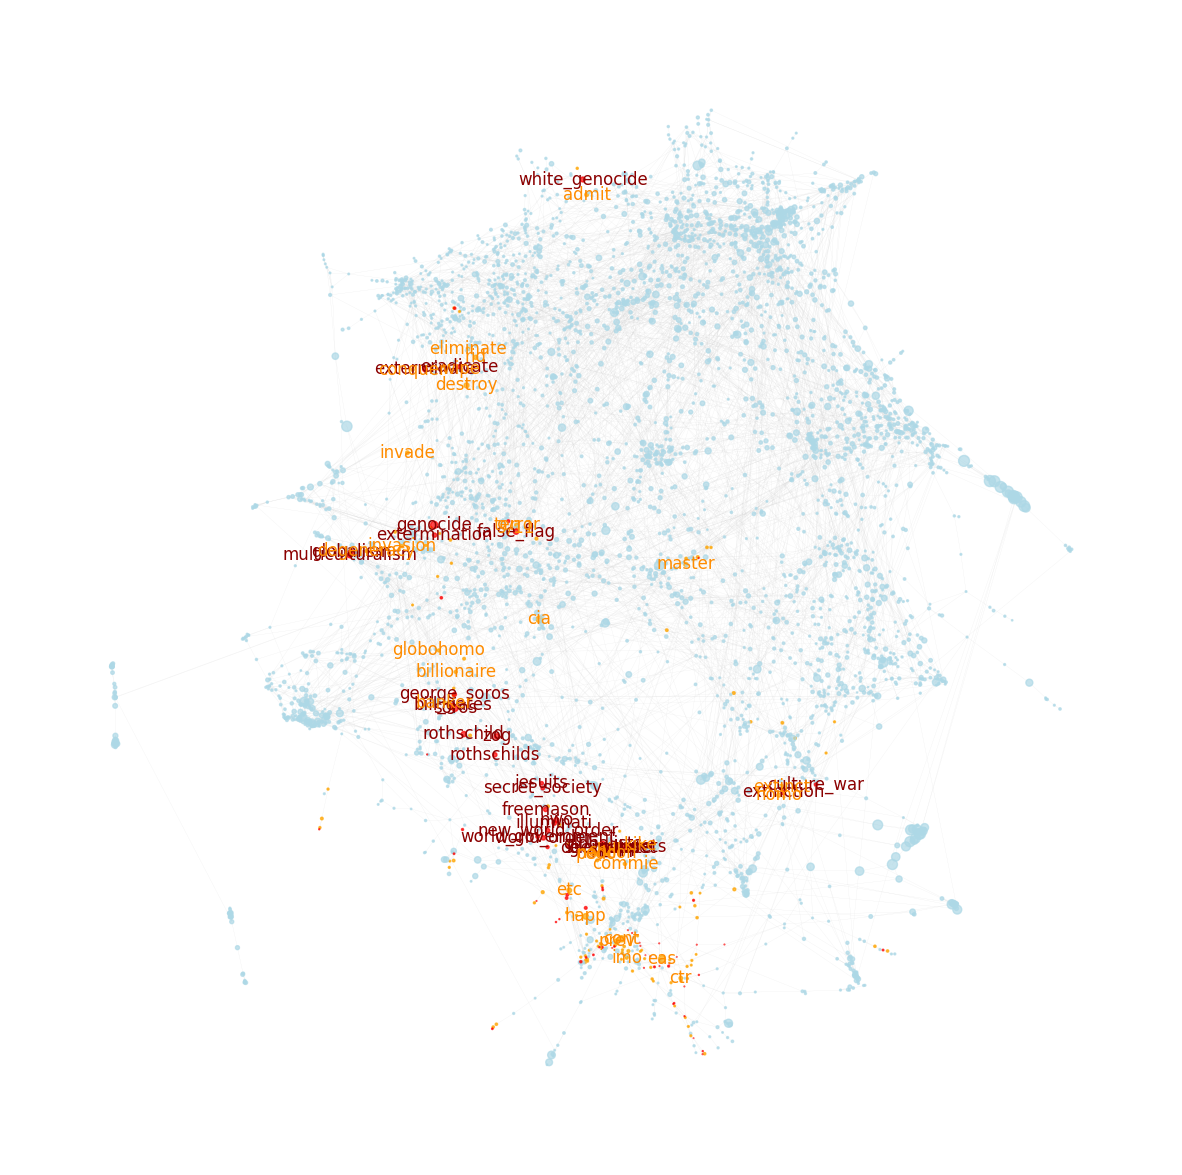

In [25]:
# visualise semantic network
lgde.construct_nx_graph()
fig = lgde.plot_semantic_network(n_top=30,doc_freq=list(doc_freq),lcc_only=True,node_size_factor=0.2,alpha=0.7,edge_width=0.1)
fig.savefig("figures/4chan_semantic_network.pdf",dpi=fig.dpi,bbox_inches="tight")


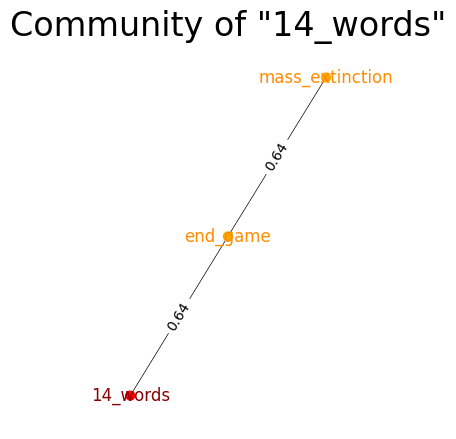

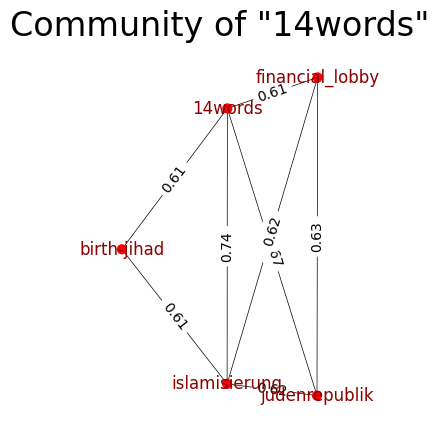

The keyword 'ausrotten' is a singleton semantic community.


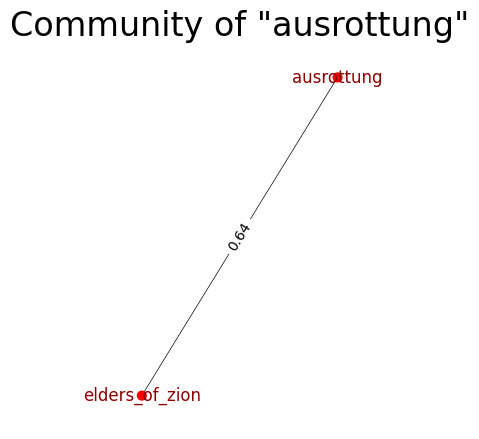

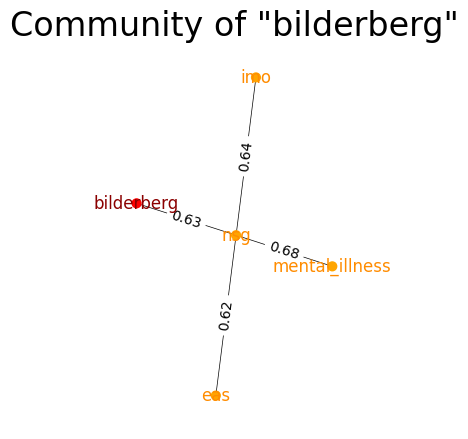

In [26]:
# plot semantic communities
lgde.plot_semantic_communities(n_plots=5,path="figures/")

In [27]:
baseline.pairwise_word_similarity("repopulation","bioweapon")

0.5869642280059744

In [28]:
baseline.pairwise_word_similarity("helter_skelter","entire_population")

0.5028712755571385

In [29]:
# expand with the optimal epsilon
thres_prime = Thresholding(seed_dict,word_list,word_vecs)
thres_prime.expand(0.5)

print("Number of discovered keywords:", thres_prime.n_discovered,"\n")

print("Train scores for thresholding discovered dictionary:\n")
_,_,_ = evaluate_prediction(thres_prime.discovered_dict_, y_train, dt_train)

print("\nTest scores for thresholding expanded dictionary:\n")
_,_,_ = evaluate_prediction(thres_prime.expanded_dict_, y_test, dt_test)

Number of discovered keywords: 4891 

Train scores for thresholding discovered dictionary:

              precision    recall  f1-score   support

       False      0.143     0.015     0.028        65
        True      0.870     0.986     0.925       435

    accuracy                          0.860       500
   macro avg      0.507     0.501     0.476       500
weighted avg      0.776     0.860     0.808       500


Test scores for thresholding expanded dictionary:

              precision    recall  f1-score   support

       False      0.667     0.013     0.025       156
        True      0.306     0.986     0.467        69

    accuracy                          0.311       225
   macro avg      0.486     0.499     0.246       225
weighted avg      0.556     0.311     0.161       225



## 5) Expert-based annotation of discovered words

### 5.1) Create annotation sheets

In [30]:
# combine all discovered words
all_discovered = set(thres.discovered_dict_ + lgde.discovered_dict_)

# # create data frame
# annotation_df = pd.DataFrame({"word" : list(all_discovered)})
# annotation_df["conspiracy-related"] = ""

# # shuffle and store excel sheet
# annotation_df_1 = annotation_df.sample(frac=1,random_state=1)
# annotation_df_1.reset_index(drop=True,inplace=True)
# annotation_df_1.to_excel("annotation/4chan-annotation-1.xlsx", index=False)

# # shuffle and store excel sheet
# annotation_df_2 = annotation_df.sample(frac=1,random_state=2)
# annotation_df_2.reset_index(drop=True,inplace=True)
# annotation_df_2.to_excel("annotation/4chan-annotation-2.xlsx", index=False)

# # shuffle and store excel sheet
# annotation_df_3 = annotation_df.sample(frac=1,random_state=3)
# annotation_df_3.reset_index(drop=True,inplace=True)
# annotation_df_3.to_excel("annotation/4chan-annotation-3.xlsx", index=False)

### 5.2) Annotation results

In [31]:
# load annotations
annotation_df_1 = pd.read_excel("annotation/4chan-annotation-1_.xlsx")
annotation_df_2 = pd.read_excel("annotation/4chan-annotation-2_.xlsx")
annotation_df_3 = pd.read_excel("annotation/4chan-annotation-3_.xlsx")

# sort alphabetically
annotation_df_1.sort_values(by="word", inplace=True)
annotation_df_2.sort_values(by="word", inplace=True)
annotation_df_3.sort_values(by="word", inplace=True)

# reset index
annotation_df_1.reset_index(drop=True, inplace=True)
annotation_df_2.reset_index(drop=True, inplace=True)
annotation_df_3.reset_index(drop=True, inplace=True)

# change column names
annotation_df_1.rename(columns={"conspiracy-related" : "y1"}, inplace=True)
annotation_df_2.rename(columns={"conspiracy-related" : "y2"}, inplace=True)
annotation_df_3.rename(columns={"conspiracy-related" : "y3"}, inplace=True)

# summarise annotations
annotation_df = pd.DataFrame()
annotation_df["word"] = annotation_df_1["word"]
annotation_df["y1"] = annotation_df_1["y1"]
annotation_df["y2"] = annotation_df_2["y2"]
annotation_df["y3"] = annotation_df_3["y3"]

# sum of votes
annotation_df["y_sum"] = annotation_df["y1"]+annotation_df["y2"]+annotation_df["y3"]

# majority vote
annotation_df["y_majority"] = np.asarray(annotation_df["y_sum"] >= 2,dtype=int)

# store results
annotation_df.to_excel("annotation/4chan-annotation-results.xlsx", index=False)

annotation_df.head(15)

,word,y1,y2,y3,y_sum,y_majority
0,2.,0,0,0,0,0
1,3.,0,0,0,0,0
2,9/11,1,1,1,3,1
3,:^,1,0,0,1,0
4,act,0,0,0,0,0
5,admit,0,0,0,0,0
6,adolf_hitler,1,0,0,1,0
7,afd,1,0,0,1,0
8,ain't,0,0,0,0,0
9,alt_right,1,0,0,1,0


In [32]:
# compute accuracies for different dictionaries
lgde_all = set(lgde.discovered_dict_)
thres_all = set(thres.discovered_dict_)
lgde_only =  lgde_all -  thres_all
thres_only = thres_all - lgde_all
intersection = lgde_all.intersection(thres_all)

print("Accuracy LGDE all:", round(annotation_df[annotation_df["word"].isin(lgde_all)]["y_majority"].mean(),4))
print("Accuracy Thres all:", round(annotation_df[annotation_df["word"].isin(thres_all)]["y_majority"].mean(),4))
print("Accuracy LGDE only:", round(annotation_df[annotation_df["word"].isin(lgde_only)]["y_majority"].mean(),4))
print("Accuracy Thres only:", round(annotation_df[annotation_df["word"].isin(thres_only)]["y_majority"].mean(),4))
print("Accuracy LGDE AND Thres:", round(annotation_df[annotation_df["word"].isin(intersection)]["y_majority"].mean(),4))

Accuracy LGDE all: 0.302
Accuracy Thres all: 0.1892
Accuracy LGDE only: 0.2897
Accuracy Thres only: 0.1321
Accuracy LGDE AND Thres: 0.3333


Cohen's kappa between annotator 1 and 2: 0.547
Cohen's kappa between annotator 1 and 3: 0.381
Cohen's kappa between annotator 2 and 3: 0.503
Mean pairwise Cohen's kappa: 0.477


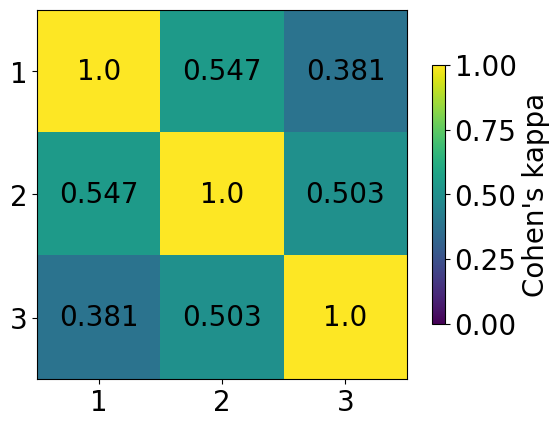

In [33]:
from sklearn.metrics import cohen_kappa_score

# compure pairwise cohen kappa score
ck_score = np.ones((3,3))

ck_score[0,1] = cohen_kappa_score(annotation_df["y1"],annotation_df["y2"])
ck_score[1,0] = ck_score[0,1]
ck_score[0,2] = cohen_kappa_score(annotation_df["y1"],annotation_df["y3"])
ck_score[2,0] = ck_score[0,2]
ck_score[1,2] = cohen_kappa_score(annotation_df["y2"],annotation_df["y3"])
ck_score[2,1] = ck_score[1,2]

print("Cohen's kappa between annotator 1 and 2:", round(ck_score[0,1],3))
print("Cohen's kappa between annotator 1 and 3:", round(ck_score[0,2],3))
print("Cohen's kappa between annotator 2 and 3:", round(ck_score[1,2],3))
print("Mean pairwise Cohen's kappa:", round((ck_score[0,1]+ck_score[0,2]+ck_score[2,1])/3,3))

# plot
fig, ax = plt.subplots(1)
im = ax.imshow(ck_score, vmin=0, vmax=1)
ax.set(xticks=[0,1,2],xticklabels=[1,2,3],yticks=[0,1,2],yticklabels=[1,2,3])
cbar = plt.colorbar(im,shrink=0.7)
cbar.set_label("Cohen's kappa")

# Loop over data dimensions and create text annotations.
for i in range(len(ck_score)):
    for j in range(len(ck_score)):
        text = ax.text(j, i, round(ck_score[i, j],3),
                       ha="center", va="center", color="black")

Fisher exact test with alternative "odds ratio greater 1": p = 0.0038


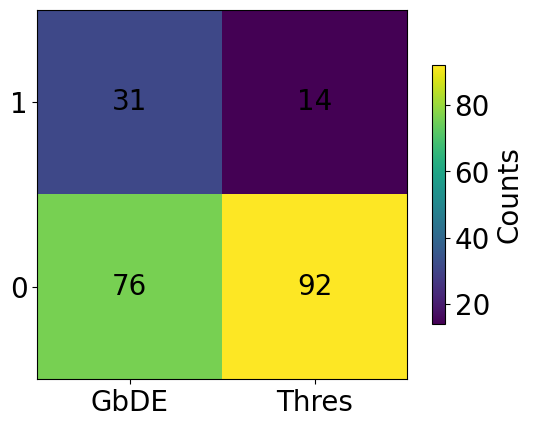

In [34]:
from scipy.stats import fisher_exact

# define contigency table
labels_lgde_only = np.asarray(annotation_df[annotation_df["word"].isin(lgde_only)]["y_majority"])
labels_thres_only = np.asarray(annotation_df[annotation_df["word"].isin(thres_only)]["y_majority"])
contingency_table = np.zeros((2,2))

contingency_table[0,0] = labels_lgde_only.sum()
contingency_table[1,0] = len(labels_lgde_only) - labels_lgde_only.sum()

contingency_table[0,1] = labels_thres_only.sum()
contingency_table[1,1] = len(labels_thres_only) - labels_thres_only.sum()

U, p = fisher_exact(contingency_table, alternative='greater')
print('Fisher exact test with alternative "odds ratio greater 1": p =', np.around(p,4))

# plot
fig, ax = plt.subplots(1)
im = ax.imshow(contingency_table)
ax.set(xticks=[0,1],xticklabels=["GbDE","Thres"],yticks=[0,1],yticklabels=["1","0"])
cbar = plt.colorbar(im,shrink=0.7)
cbar.set_label("Counts")

for i in range(len(contingency_table)):
    for j in range(len(contingency_table)):
        text = ax.text(j, i, round(contingency_table[i, j]),
                       ha="center", va="center", color="black")

### 5.3) Print discovered words for LaTeX

Words that are conspiracy-related according to the majority vote should be bold in LaTeX table.

In [35]:
# get word annotation dict
word_annotation = annotation_df[["word","y_majority"]].set_index("word")["y_majority"].to_dict()

In [36]:
def print_latex_table(dict_left,dict_right):

    dict_left = set(dict_left)
    dict_right = set(dict_right)

    # compute intersection and unique keywords
    intersect = sorted(list(dict_left.intersection(dict_right)))
    dict_left_unique = sorted(list(dict_left - dict_right))
    dict_right_unique = sorted(list(dict_right - dict_left))

    string_output = "a) & "

    for word in dict_left_unique:
        if word_annotation[word] == 1:
            string_output+="\textbf{"+str(word).replace("_","\_")+"}, "
        else:
            string_output+=str(word).replace("_","\_")+", "

    string_output += "\\ \hline b) & "

    for word in intersect:
        if word_annotation[word] == 1:
            string_output+="\textbf{"+str(word).replace("_","\_")+"}, "
        else:
            string_output+=str(word).replace("_","\_")+", "

    string_output += "\\ \hline c) & "

    for word in dict_right_unique:
        if word_annotation[word] == 1:
            string_output+="\textbf{"+str(word).replace("_","\_")+"}, "
        else:
            string_output+=str(word).replace("_","\_")+", "

    string_output += " \\ "

    return string_output

In [37]:
print_latex_table(lgde.discovered_dict_,thres.discovered_dict_)

"a) & :^, adolf\\_hitler, afd, ain't, alt\\_right, amalek, american\\_government, architect, bannon, \textbf{bioweapon}, \textbf{bogdanoffs}, bombing, btfo, \textbf{cabal}, cattle, civic\\_nationalism, cold\\_war, communist\\_party, cont, ctr, cull, death\\_camp, \textbf{disguis}, donald\\_trump, durr, eas, \textbf{end\\_game}, end\\_result, \textbf{end\\_time}, engineering, \textbf{entire\\_population}, etc, executive\\_order, expulsion, extermination\\_camp, \textbf{false\\_narrative}, \textbf{false\\_prophet}, general\\_public, george\\_washington, gib, \textbf{globalist\\_jews}, \textbf{globalist\\_puppet}, \textbf{globohomo}, \textbf{golem}, \textbf{good\\_goy}, good\\_job, good\\_people, great\\_ally, hahaha, hahahaha, happ, homo, hurr, imo, international\\_criminal\\_court, invasion, \textbf{israeli\\_puppet}, \textbf{jeff\\_bezos}, jesus\\_christ, \textbf{jewish\\_plan}, \textbf{jewish\\_role}, \textbf{jewish\\_state}, \textbf{jp\\_morgan}, \textbf{juden}, kamala\\_harris, lebe